# Exploratory Data Analysis

## 0. Overview

### 0.1. Background
- COVID-19는 감염자의 입, 호흡기로부터 나오는 비말, 침 등으로 쉽게 전파된다.
- COVID-19의 감염 확산을 막기 위해서는 모든 사람이 마스크를 올바르게 착용하여 전파 경로를 원천 차단해야 한다.
- 올바르게 착용한다는 것은 코와 입을 완전히 가리는 것을 말한다.
- 넓은 공공장소에서 모든 사람들의 올바른 마스크 착용 상태를 검사하기 위해서는 추가적인 인적자원이 필요하다.

### 0.2. Problem Definition
카메라로 비춰진 사람 얼굴 이미지 만으로 이 사람이 마스크를 쓰고 있는지, 쓰지 않았는지, 정확히 쓴 것이 맞는지를 분류하는 모델
- `input`: $384\times512$ 크기의 마스크를 쓴 사람의 얼굴 이미지
- `output`: 18개의 클래스 (마스크 착용여부, 성별, 나이)로 나타낼 수 있는 조합
    - 마스크 착용여부: Wear, Incorrect, Not Wear
    - 성별: Male, Female
    - 나이: <30, >=30 and <60, >=60

### 0.3. Evaluation Standard

f1-score는 데이터가 불균형할 때 쓰기 좋은 지표로 알려져 있다. 그러므로 데이터가 클래스별로 불균형한지 확인해보자.

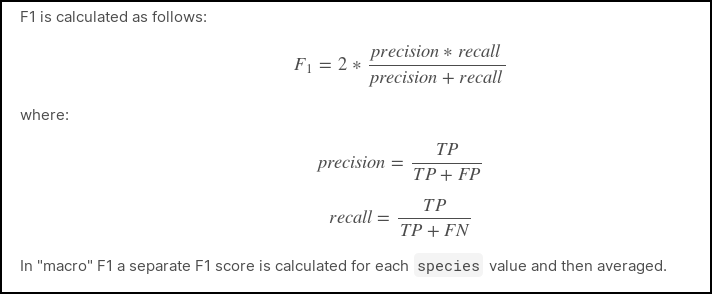

### 0.4. Class Description
- `Mask - Gender - Age` 순으로 정렬

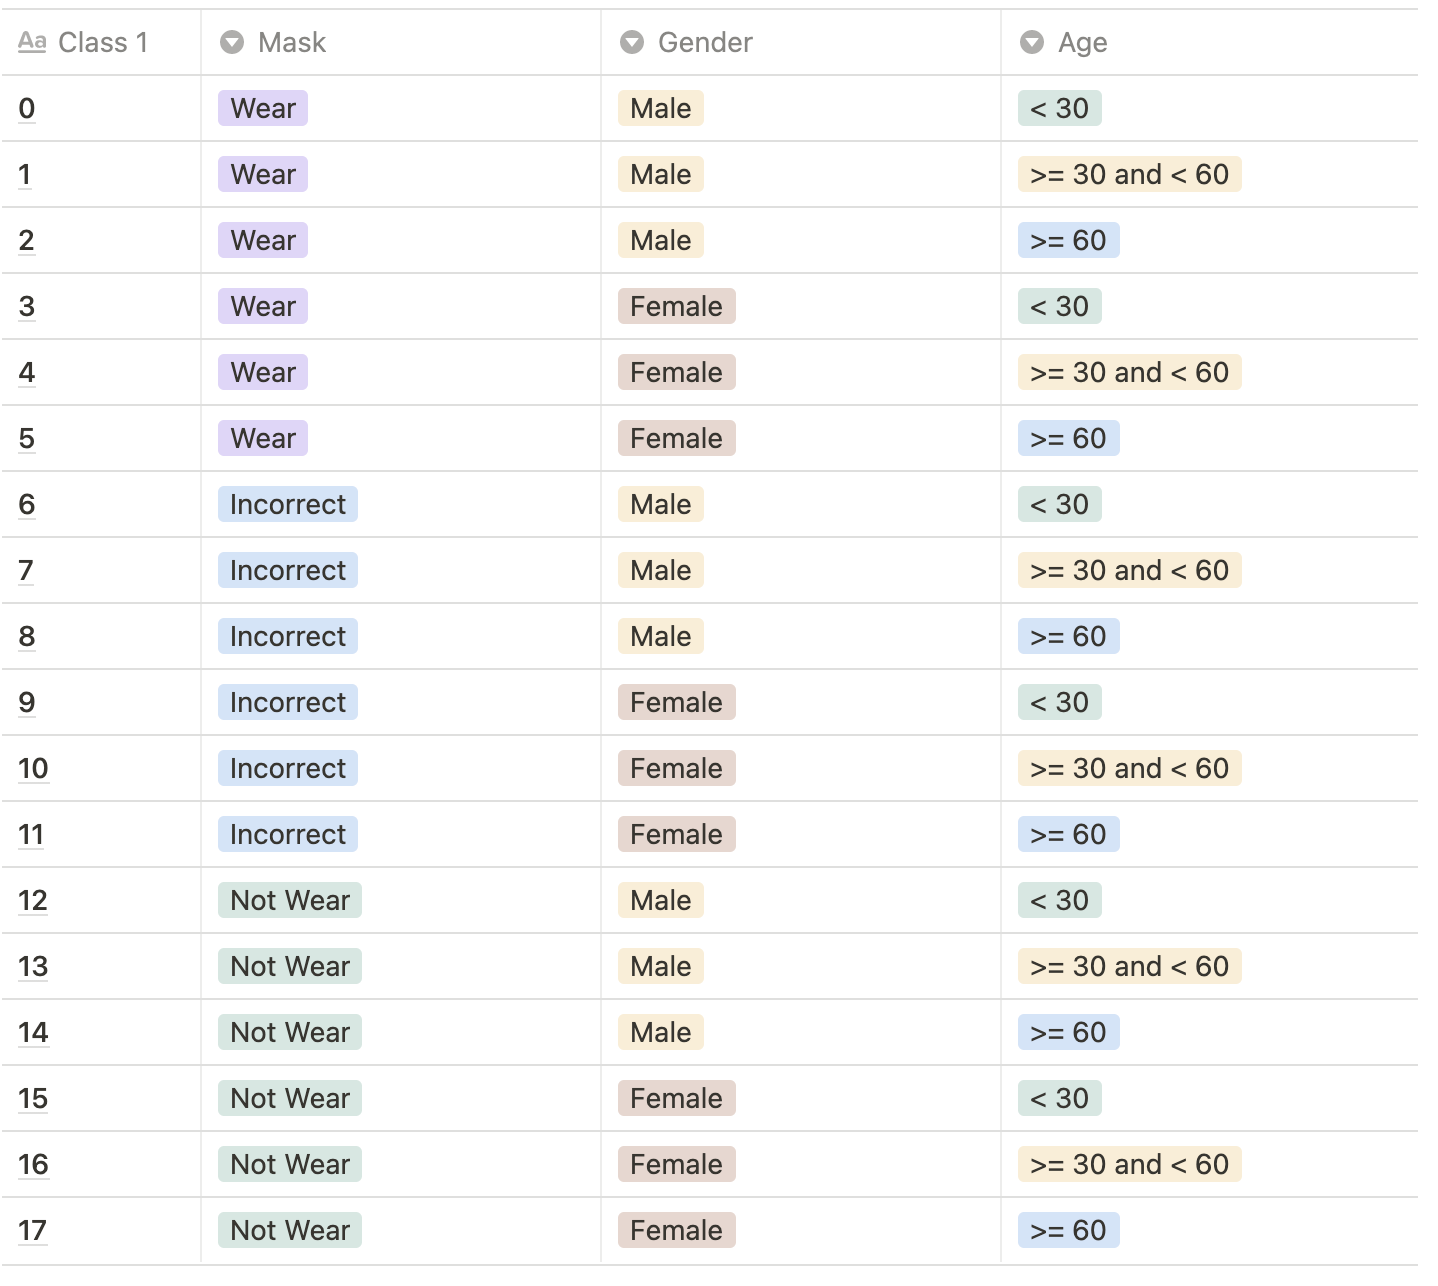

## 1. Imports and Setting

In [1]:
# cv2 import 오류 시 실행
# !apt-get install libgl1-mesa-glx -y

In [2]:
import os
import sys
from glob import glob
from time import time
from tqdm.notebook import tqdm

# data processing
import cv2
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'tqdm'

In [3]:
# 파일 경로 사용자 정의
class path:
    train = '../input/data/train'
    train_img = f'{train}/images'
    train_df = f'{train}/train.csv'
    test = '../input/data/eval'
    test_img = f'{test}/images'
    test_df = f'{test}/info.csv'

In [4]:
# 문자열 클래스 라벨을 숫자로 변환하는 딕셔너리 정의
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}
class2num

{'incorrect_mask': 0,
 'mask1': 1,
 'mask2': 2,
 'mask3': 3,
 'mask4': 4,
 'mask5': 5,
 'normal': 6}

## 2. Load Data

### 2.1. Train Data

In [5]:
df = pd.read_csv(path.train_df)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


- 결측치 및 피처별 자료형 확인

In [6]:
# 결측치, 피처별 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


- 데이터의 크기와 피처 확인

In [7]:
# 데이터 크기
print(f"Number of data: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print(f"Features: {list(df.columns)}")

Number of data: 2700
Number of features: 5
Features: ['id', 'gender', 'race', 'age', 'path']


- `id`: 데이터 id
- `gender`: 성별
- `race`: 인종
- `age`: 나이
- `path`: 이미지 폴더명

- 데이터의 개수와 이미지 폴더의 개수가 일치하는지 확인

In [8]:
folder = glob(f'{path.train_img}/*')
print(f'데이터와 폴더의 개수가 일치하는가: {df.shape[0] == len(folder)}')

데이터와 폴더의 개수가 일치하는가: True


### 2.2. Evaluation Dataset

In [9]:
df_ev = pd.read_csv(path.test_df)
df_ev.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


- 결측치 및 자료형 확인

In [10]:
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  12600 non-null  object
 1   ans      12600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 197.0+ KB


- 데이터 크기와 피처 확인

In [11]:
# 데이터 크기
print(f"Number of data: {df_ev.shape[0]}")
print(f"Number of features: {df_ev.shape[1]}")
print(f"Features: {list(df_ev.columns)}")

Number of data: 12600
Number of features: 2
Features: ['ImageID', 'ans']


이미지 아이디와 이미지별 클래스로 구성되어 있으며, 성별/나이/마스크 착용 여부 관련 피처는 존재하지 않는다. 그러므로 각각에 대한 분류기를 만든 후 각 분류기의 결과를 합쳐서 최종 클래스를 결정하는 식으로 설계를 해야할 듯. 즉, 타겟값이 총 3개인 것!

## 3. Data Analysis

학습데이터를 가지고 `gender`, `race`, `age` 별 분포를 살펴보자. 참고로 마스크 여부의 분포를 살펴보지 않는 이유는 **마스크 착용 5장, 이상하게 착용 1장, 미착용 1장**으로 사진이 구성되어 있으므로 굳이 분포를 살펴보지 않아도 된다.

### 3.1. Metadata

#### 3.1.1. Gender

- `gender`의 고유값과 value별 개수

In [12]:
print(f"unique values: {list(df.gender.unique())}")
df.gender.value_counts()

unique values: ['female', 'male']


female    1658
male      1042
Name: gender, dtype: int64

- `gender`의 분포 시각화

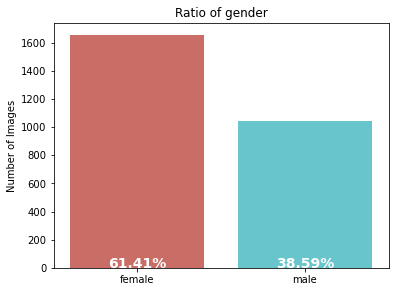

In [13]:
plt.figure(figsize=(6, 4.5))
ax = sns.countplot(x='gender', data=df, palette='hls')

plt.xticks(np.arange(2), ['female', 'male'])
plt.title("Ratio of gender")
plt.xlabel('')
plt.ylabel('Number of Images')

counts = df.gender.value_counts()
counts_pct = [f'{pct*100:.2f}%' for pct in counts/counts.sum()]
for idx, value in enumerate(counts_pct):
    ax.text(idx, 0, value, horizontalalignment='center', size=14, color='w', fontweight='bold')

plt.show()

여성이 남성보다 약 1.6배 정도 많다.

#### 3.1.2. Race

- `race`의 고유값과 value별 개수

In [14]:
print(f"unique values: {list(df.race.unique())}")
df.race.value_counts()

unique values: ['Asian']


Asian    2700
Name: race, dtype: int64

인종은 모두 Asian이므로 굳이 고려할 필요는 없는 피처로 보인다. 또한 클래스 라벨에 인종에 해당하는 내용은 없으므로 제거하자.

#### 3.1.3. Age

- `age`의 고유값과 최소/최대값

In [15]:
ages = sorted(df.age.unique())
for i in ages:
    print(i, end=' ')
    if not i%10:
        print()

18 19 20 
21 22 23 24 25 26 27 28 29 30 
31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 
51 52 53 54 55 56 57 58 59 60 


In [16]:
df.age.describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

`age`는 정수이지만 자료형은 실수이며, 최소값은 18이고 최대값은 60임을 알 수 있다.

- `age`의 확률분포

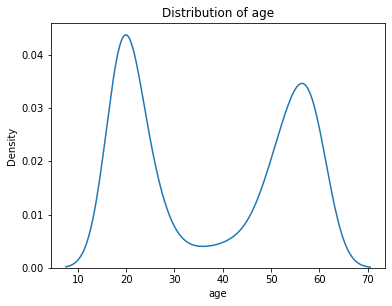

In [17]:
plt.figure(figsize=(6, 4.5))
sns.kdeplot(x='age', data=df)
plt.title("Distribution of age")
plt.show()

20대 초반이 많고 30대에서 40대는 적으며 50대, 60대 고연령층이 많은 것을 볼 수 있다.

- `age`를 "30살 미만", "30살 이상 60살 미만", "60살 이상"으로 구간 나누기

In [18]:
def get_age_bin(x): 
    if x <30:
        return 0
    elif x >=30 and x <58:
        return 1
    else:
        return 2
    
df['age_bin'] = df.age.map(get_age_bin)
df

,id,gender,race,age,path,age_bin
0,000001,female,Asian,45,000001_female_Asian_45,1
1,000002,female,Asian,52,000002_female_Asian_52,1
2,000004,male,Asian,54,000004_male_Asian_54,1
3,000005,female,Asian,58,000005_female_Asian_58,2
4,000006,female,Asian,59,000006_female_Asian_59,2
...,...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19,0
2696,006955,male,Asian,19,006955_male_Asian_19,0
2697,006956,male,Asian,19,006956_male_Asian_19,0
2698,006957,male,Asian,20,006957_male_Asian_20,0


- `age_bin` 분포 시각화

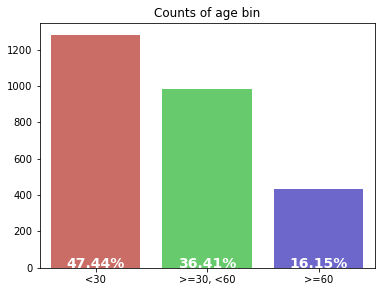

In [19]:
plt.figure(figsize=(6, 4.5))
ax = sns.countplot(x='age_bin', data=df, palette='hls')

plt.xticks(np.arange(3), ['<30', '>=30, <60', ">=60"])
plt.title("Counts of age bin")
plt.xlabel('')
plt.ylabel('')

counts = df.age_bin.value_counts()
counts_pct = [f'{pct*100:.2f}%' for pct in counts/counts.sum()]
for idx, value in enumerate(counts_pct):
    ax.text(idx, 0, value, ha='center', size=14, color='w', fontweight='bold')

plt.show()

"30세 미만"이 제일 많고 그 다음에 "30세 이상, 60세 미만"이 많으며 "60세 이상"은 매우 적은 것을 볼 수 있다. 그럴 수 밖에 없는 것이 60세 이상은 60살 밖에 존재하지 않기 때문이다.

#### 3.1.4. Gender and Age

- 각 성별의 나이 분포 시각화

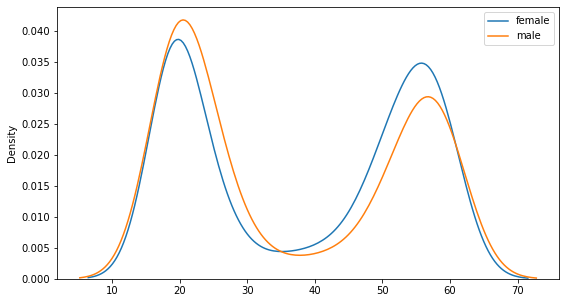

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.set_palette('hls')

sns.kdeplot(df[df['gender'] == 'female']['age'], ax=ax)
sns.kdeplot(df[df['gender'] == 'male']['age'], ax=ax)

plt.xlabel('')
plt.legend(['female', 'male'])

plt.show()

각 성별의 나이 분포는 크게 차이가 나지 않는 것으로 보인다.

- 나이대 별 성별 분포 시각화

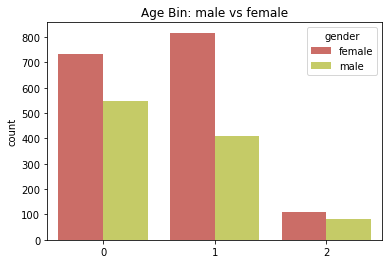

In [22]:
sns.countplot('age_bin', hue='gender', data=df)
plt.title('Age Bin: male vs female')
plt.xlabel('')
plt.show()

모든 나이대에서 여성이 많지만, "30대 이상, 60대 미만"에서는 여성이 2배 가까이 많으며, "60대 이상"에서는 다른 나이대에 비해 비슷한 것을 볼 수 있다.

In [23]:
crosstab = pd.crosstab(df.age_bin, df.gender)
crosstab.index = ['<30', '>=30, <60', '>60']
crosstab

gender,female,male
<30,732,549
">=30, <60",817,410
>60,109,83


`crosstab`으로 실제 데이터를 보면 위의 그래프를 보고 한 판단이 옳은 것을 볼 수 있다.

#### 3.1.5. Gender, Age and Mask

- 클래스 조합 생성

In [24]:
from itertools import product

mask = ['wear', 'incorrect', 'not wear']
gender = ['male', 'female']
age_bin = [0, 1, 2]

classes = list(product(mask, gender, age_bin))
classes

[('wear', 'male', 0),
 ('wear', 'male', 1),
 ('wear', 'male', 2),
 ('wear', 'female', 0),
 ('wear', 'female', 1),
 ('wear', 'female', 2),
 ('incorrect', 'male', 0),
 ('incorrect', 'male', 1),
 ('incorrect', 'male', 2),
 ('incorrect', 'female', 0),
 ('incorrect', 'female', 1),
 ('incorrect', 'female', 2),
 ('not wear', 'male', 0),
 ('not wear', 'male', 1),
 ('not wear', 'male', 2),
 ('not wear', 'female', 0),
 ('not wear', 'female', 1),
 ('not wear', 'female', 2)]

- 클래스 별 개수 계산

In [25]:
counts = []
for mask, gender, age in classes:
    count = df[(df['gender']==gender)&(df['age_bin']==age)].shape[0]
    if mask=='wear':
        count = count*5
    counts.append(count)
counts

[2745,
 2050,
 415,
 3660,
 4085,
 545,
 549,
 410,
 83,
 732,
 817,
 109,
 549,
 410,
 83,
 732,
 817,
 109]

- 클래스별 개수 시각화

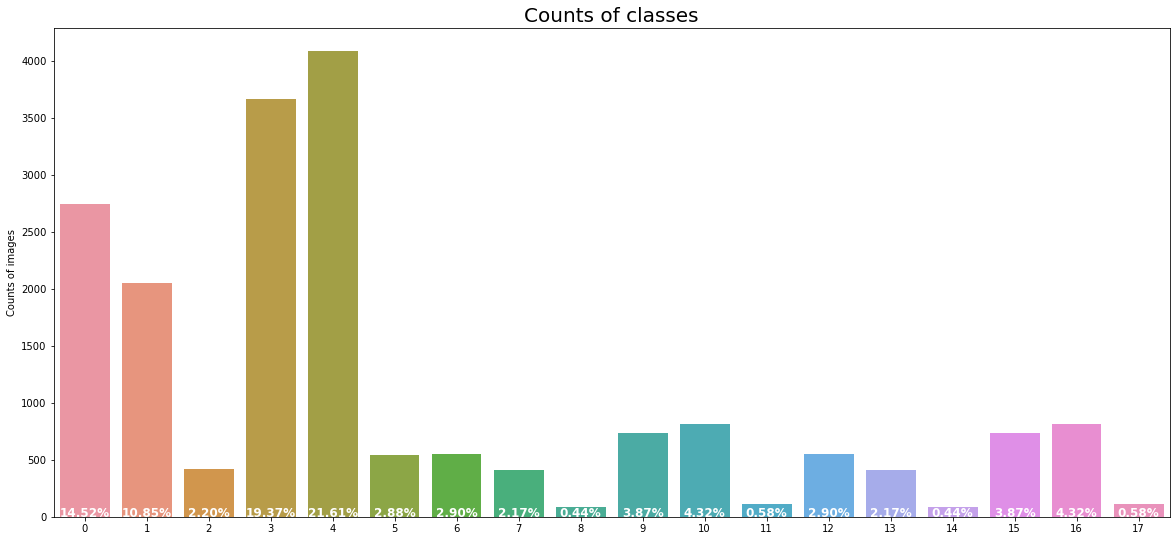

In [26]:
plt.figure(figsize=(20, 9))
ax = sns.barplot(x=np.arange(18), y=counts)

plt.title('Counts of classes', fontsize=20)
plt.ylabel('Counts of images')

count_sum = sum(counts)
pcts = [f'{i/count_sum*100:.2f}%' for i in counts]
for idx, value in enumerate(pcts):
    ax.text(idx, 0, value, ha='center', color='w', fontweight='bold', size=12)

plt.show()

여성이고 "30대 미만", "30대 이상 60대 미만"이고 마스크를 착용한 경우 데이터의 수가 가장 많은 것을 볼 수 있고, 동일한 조건의 남자인 경우가 그 다음으로 많은 것을 볼 수 있다.

클래스 불균형이 나타나기 때문에 oversampling하거나 loss term을 다르게 주는 등으로 불균형을 해결해야 한다.

### 3.2. Image

#### 3.2.1. Image Visualization

- 시각화에 필요한 함수 정의

In [27]:
def get_ext(img_dir, img_id):
    '''
    이미지의 확장자(.jpg, .jpeg)를 구한다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
         ext: 이미지의 확장자
    ''' 
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [28]:
def plot_raw_image(img_dir, img_id):
    '''
    마스크 미착용 이미지를 시각화한다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    '''
    ext = get_ext(img_dir, img_id)
    img = np.array(Image.open(os.path.join(img_dir, img_id, 'normal' + ext)))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)

In [29]:
def plot_mask_images(img_dir, img_id):
    '''
    마스크 정상착용 5장과 이상하게 착용한 1장을 2x3의 격자에 시각화한다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    '''
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 1, 6
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))
    for i in range(n_rows*n_cols):
        axes[i].imshow(imgs[i])
        axes[i].set_title(f'{num2class[i]}', color='r', fontweight='bold')
    plt.tight_layout()

- 예시 이미지로 함수 사용해보기

In [30]:
# 100번째 데이터의 이미지 확장자
img_id = df.iloc[100].path
ext = get_ext(path.train_img, img_id)
ext

'.jpg'

In [5]:
# 100번째 이미지의 맨 얼굴 이미지
# plot_raw_image(path.train_img, img_id)

In [6]:
# 100번째 이미지의 마스크를 쓴 이미지 시각화
# plot_mask_images(path.train_img, img_id)

- 랜덤으로 이미지 id를 추출해 확인해보기

In [7]:
import random

random_num = random.randint(0, 2699)
data = df.iloc[random_num]
img_id = data.path
gender = data.gender
age = data.age
age_bin = data.age_bin
print(f'{random_num}번째 데이터의 마스크 이미지')
print(f'>> 성별: {gender}')
print(f'>> 나이: {age}')
print(f'>> 나이대: {age_bin}')
# plot_mask_images(path.train_img, img_id)

NameError: name 'df' is not defined

마스크 이미지를 랜덤으로 추출해서 확인해본 결과가 이미지가 다음과 같은 특징을 가지고 있음을 확인하였다.

- 이상하게 마스크를 착용하는 경우
    - 턱까지 덮지 않음(코스크)
    - 입과 턱만 덮음(턱스크)
    - 눈에다 착용
    - 얼굴 전체를 덮음
    - 애매한 경우(콧구멍이 보이진 않고 코가 다른 사진에 비해 좀 더 노출되는 경우)
- 마스크의 색과 무늬가 다양하다.
    - 노란색 / 하늘색 / 하얀색 / 핑크색 / 검은색
    - 꽃무늬 / 체크무늬 / 도트무늬 / 유아용 패턴 / 민트색 사탕 / 그 외 다양한 패턴
    - 손수건
    - 💡 grayscale로 색을 없애는 시도를 해보자.
- 명도가 제각각임 / 흐린 사진도 있음 / 항상 상반신 정자세가 아니라 얼굴만 찍힌 것도 있음(CenterCrop시 조심)
   - 💡 밝기를 평균값으로 바꾸는 것 시도

#### 3.2.2. Image Statistics

In [34]:
def get_img_stats(img_dir, img_ids):
    '''
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집한다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    '''
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            height, width, _ = img.shape
            img_info['heights'].append(height)
            img_info['widths'].append(width)
            img_info['means'].append(img.mean(axis=(0, 1)))
            img_info['stds'].append(img.std(axis=(0, 1)))
    return img_info

In [36]:
img_info = get_img_stats(path.train_img, df.path.values)

In [41]:
print(f'총 데이터의 개수: {len(df)}')
print(f'총 이미지의 개수: {len(df) * 7}\n')

print(f'이미지의 최소 height: {np.min(img_info["heights"])}')
print(f'이미지의 최대 height: {np.max(img_info["heights"])}')
print(f'이미지의 평균 height: {int(np.mean(img_info["heights"]))}\n')

print(f'이미지의 최소 width: {np.min(img_info["widths"])}')
print(f'이미지의 최대 width: {np.max(img_info["widths"])}')
print(f'이미지의 평균 width: {int(np.mean(img_info["widths"]))}\n')

print(f'RGB 평균: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB 표준편차: {np.mean(img_info["stds"], axis=0) / 255.}')

총 데이터의 개수: 2700
총 이미지의 개수: 18900

이미지의 최소 height: 512
이미지의 최대 height: 512
이미지의 평균 height: 512

이미지의 최소 width: 384
이미지의 최대 width: 384
이미지의 평균 width: 384

RGB 평균: [0.56019358 0.52410121 0.501457  ]
RGB 표준편차: [0.23318603 0.24300033 0.24567522]
